# Segmentation-models

### Multi-class Segmentation
- 이미지 픽셀 당 한 번의 분류를 수행
    - 한 픽셀 자리에서 Softmax를 통해 여러 장의 segmentation map 중 대표적인 값을 선택
    - 픽셀 당 클래스가 상호 배타적임
- 한 픽셀은 무조건 하나의 카테고리로만 분류
- 마스크가 겹치지 않음
- 최종적인 마스크는 (1, H, W)로 축약할 수 있음
![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FBhPDc%2FbtrFUM91Xaa%2FWT9ysDK2jkQmlqZeCdkL11%2Fimg.png)

### Multi-label Segmentation
- 이미지 픽셀 당 Class_num 번 분류를 수행
    - 한 Segmentation map은 다른 map과 공존할 수 있음
    - 각 픽셀은 총 Class_num 만큼의 sigmoid 계산을 통해 해당  클래스 종속 여부를 판별함
- 한 픽셀은 여러 개의 클래스에 속할 수 있음
- 마스크가 동일 영역에 겹칠 수 있음
- 최종적인 마스크를 (1, H, W) 형태로 축약할 수 없고, 반드시 (1, C, H, W) 형태만 사용해야 함
![](https://www.kaggleusercontent.com/kf/19102645/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0..RRX-XNJRBAcyAZqEPOcioQ.PmKGfJfwxu3mLzv8eUF3uPrql0VmRsROtUHCXpDueeOOewVe0NK0KZBiXIYri7l8LM85BXjPOCN29IwHnWEnXVdkMYRiO5bOv2lGZgV7QWr1SOh_LLbmXgR22TRIuJzTLP_yiDjScB41IuPCcJG_u-aICAswNWzmCTj1VMSkbUJzek_LBcJB26u_RohkqxRPFZiBWVYdtHqk1MI15lEZGDAqbF3V6D4_olW7Y2kf0L_KMzWJvKxrEI9zrbz48-0qOBJ_q95goVhZWjA_hDL-qm6TIcqOd4cNbhC8H6M_55qwsojFp0_1nAhmxgrPLFYwF1yFAyVTca2YWvqJYHuwfsBhNKFEB36wtXwrFnmQWDrWL9beVN-S9iIzl-Mf5xtf6fQFu1f-Z4pQbKstbXGkgYdGyoxhiW7FR0JMWyBjGB83IIsyFjmpXCDrLvJqOI99GeA8bxNx1_Ziv7_9Qmfs_nMrLdK2TWpgwLAScPxyS17OQzKULPclyqZmQONQaLilxIm4XORZ8M0l0XzFCNj9q5-zdUSOws7DdPtAxWgvIGrL44qcf4saBJTP9xbh_poHNkXNehpJNWCR0dlbN5bTuzDBbagXusCTqkzO5uI6xDTq-OyfqXl-4X--CiHgv-Ms4O9n0sEIlpQ4_jZOql8jfQ.mr8-HbQWAUOJd_HyFP8Xgw/__results___files/__results___23_9.png)

In [1]:
!pip install segmentation-models-pytorch -q

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from glob import glob
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision
from torchvision import models
from torchvision import transforms

import segmentation_models_pytorch as smp

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 데이터 확인

In [5]:
image_list = glob('/kaggle/input/car-segmentation/car-segmentation/images/*')

mask_list = glob('/kaggle/input/car-segmentation/car-segmentation/masks/*')
len(image_list), len(mask_list)

(211, 211)

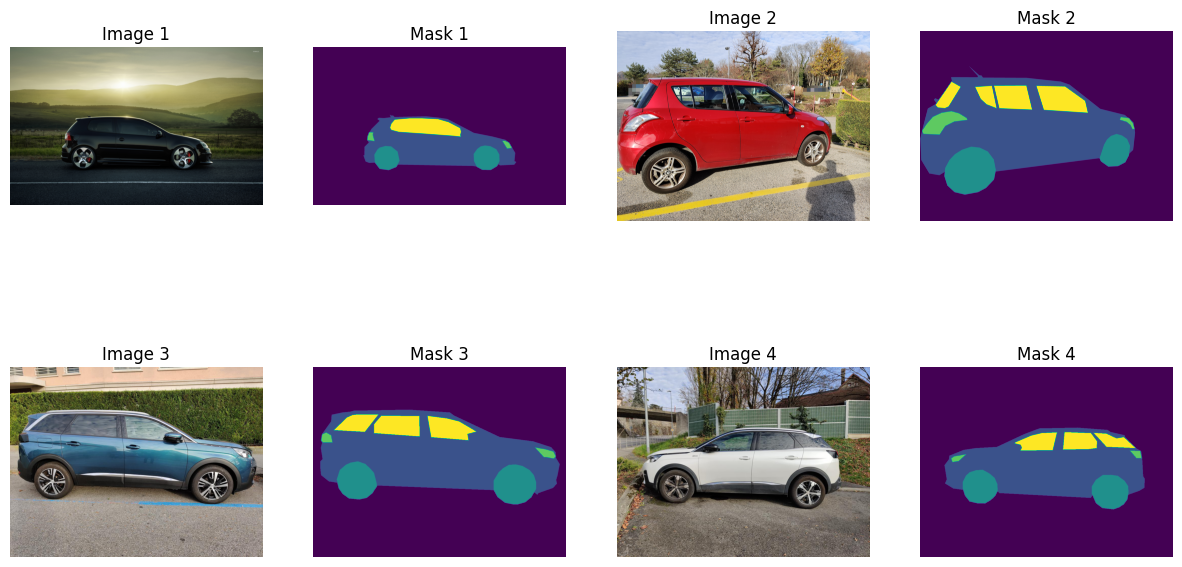

In [6]:
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
axes = axes.flatten()

for i in range(4):
    img_path = image_list[i]
    mask_path = image_list[i].replace('images', 'masks')
    
    axes[2 * i].imshow(Image.open(img_path))
    axes[2 * i].set_title(f'Image {i+1}')
    axes[2 * i].axis('off')
    
    axes[2 * i + 1].imshow(Image.open(mask_path))
    axes[2 * i + 1].set_title(f'Mask {i+1}')
    axes[2 * i + 1].axis('off')

### 클래스 확인

In [7]:
with open('/kaggle/input/car-segmentation/car-segmentation/classes.txt', 'r') as f:
    cls_list = f.read().split(',')
    cls_list = [cls.strip() for cls in cls_list]
print(cls_list)
num_classes = len(cls_list)

['background', 'car', 'wheel', 'lights', 'window']


### 마스크 고유값 확인

In [8]:
unique, counts = np.unique(mask_list, return_counts=True)
for mask_path in mask_list:
    mask = Image.open(mask_path)
    mask = np.array(mask)
    print(mask)
#     print(mask.shape)
    print(np.unique(mask))
    break

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[0 1 2 3 4]


### 이미지-마스크 겹쳐 그리기
`torchvision.utils.draw_segmentation_masks`

In [9]:
def imgs_with_masks(img_dir, start):
    img_dir = img_dir[start: start + 4]
    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    
    for i, img_path in enumerate(img_dir):
        # 이미지 및 마스크 불러오기
        img = torchvision.io.read_image(img_path)
        mask = torchvision.io.read_image(img_path.replace('images', 'masks')).squeeze(0)  # 마스크에서 불필요한 채널 제거

        # 마스크를 원-핫 인코딩하여 5개의 클래스로 변환
        one_hot_mask = F.one_hot(mask.to(torch.int64), num_classes=num_classes).permute(2, 0, 1).float()
        print(img.shape, mask.shape, one_hot_mask.shape)
        
        # 각 마스크 채널을 True/False로 변환하여 오버레이 생성
        overlayed = torchvision.utils.draw_segmentation_masks(img, 
                                                              one_hot_mask.to(torch.bool), 
                                                              alpha=0.5, 
                                                              colors=['black', 'green', 'blue', 'yellow', 'purple'])

        axes[i].imshow(overlayed.permute(1, 2, 0))
        axes[i].axis('off')
        axes[i].set_title(f'Image {i+1}')

torch.Size([3, 1600, 2560]) torch.Size([1600, 2560]) torch.Size([5, 1600, 2560])
torch.Size([3, 3000, 4000]) torch.Size([3000, 4000]) torch.Size([5, 3000, 4000])
torch.Size([3, 750, 1000]) torch.Size([750, 1000]) torch.Size([5, 750, 1000])
torch.Size([3, 750, 1000]) torch.Size([750, 1000]) torch.Size([5, 750, 1000])


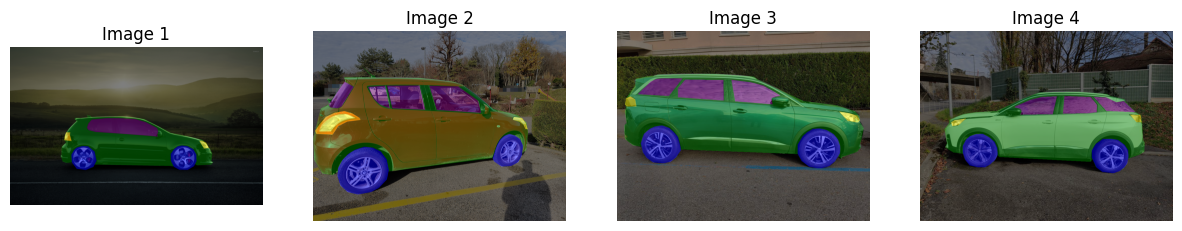

In [10]:
imgs_with_masks(image_list, 0)

### 3차원이 아닌 이미지 제거

In [11]:
exclude = []

for img_path in image_list:
    img = Image.open(img_path)
    img = np.array(img)
    if img.ndim != 3:
        print(img.shape)
        print(img.ndim)
        print(img_path)
        exclude.append(img_path)

(298, 700)
2
/kaggle/input/car-segmentation/car-segmentation/images/car-side.png
(240, 600)
2
/kaggle/input/car-segmentation/car-segmentation/images/156551_preview.png
(350, 928)
2
/kaggle/input/car-segmentation/car-segmentation/images/Car.png


In [12]:
for ex in exclude:
    image_list.remove(ex)
    mask_list.remove(ex.replace('images', 'masks'))

### Dataset
- Image: (B, 3, H, W)
- Mask: (B, H, W)

In [13]:
class CarDataset(Dataset):
    def __init__(self, image_list, mask_list, transform_img, transform_mask, num_classes=num_classes):
        
        self.image_list = image_list
        self.mask_list = mask_list
        self.transform_img = transform_img
        self.transform_mask = transform_mask
        self.num_classes = num_classes
        
    def __len__(self):
        
        return len(self.image_list)
    
    def __getitem__(self, idx):
        
        image_path = self.image_list[idx]
        mask_path = image_path.replace('images', 'masks')
        
        image = Image.open(image_path)
        mask = torchvision.io.read_image(mask_path)
        
        
        # 이미지 Channel=4 -> RGBA
        if image.mode == 'RGBA':
            image = image.convert('RGB')
        
        image = self.transform_img(image)
        mask = self.transform_mask(mask).squeeze(0).to(torch.long)
        
        return image, mask

In [14]:
transform_img = transforms.Compose([transforms.ToTensor(), 
                                    transforms.Resize((224, 224)), 
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                   ])

transform_mask = transforms.Compose([transforms.Resize((224, 224)),
                                    ])

In [15]:
car_dataset = CarDataset(image_list, mask_list, transform_img, transform_mask)
print(car_dataset.__len__())

train_size = int(0.8 * len(car_dataset))
val_size = len(car_dataset) - train_size

train_ds, val_ds = random_split(car_dataset, [train_size, val_size])
print(f"Train dataset size: {len(train_ds)} | Validation dataset size: {len(val_ds)}")

train_dl = DataLoader(train_ds, batch_size = 16, shuffle = True)
val_dl = DataLoader(val_ds, batch_size = 16, shuffle = False)

imgs, masks = next(iter(train_dl))
print(imgs.shape, masks.shape)

208
Train dataset size: 166 | Validation dataset size: 42
torch.Size([16, 3, 224, 224]) torch.Size([16, 224, 224])


## 학습 및 추론

### SMP 모델

- [Model](https://smp.readthedocs.io/en/latest/models.html)

- [Encoder](https://smp.readthedocs.io/en/latest/encoders.html)

- Pretrained weight

주의사항
- 모델에 요구되는 input/output shape이 서로 다름
- 모델마다 사용할 수 있는 encoder(backbone)의 종류가 다름

In [16]:
unet = smp.Unet('resnet34', encoder_weights='imagenet', in_channels=3, classes=5)
unet.to(device)
unet

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

### [SMP losses](https://smp.readthedocs.io/en/latest/losses.html)
- 모델 prediction mask 유형에 따라 `mode` 인자는 다음 세 가지로 나뉨
    - `binary`: 이진 분류
        - Pred: (N, 1, H, W)
        - Target: (N, H, W)
        - Target 값은 0, 1
    - `multiclass`: 다중 클래스
        - Pred: (N, C, H, W), C = number of classes
        - Target: (N, H, W)
        - Target 마스크의 unique value는 0, 1, 2, ..., C - 1
    - `multilabel`: 다중 레이블
        - Pred: (N, C, H, W), C = number of classes
        - Target: (N, C, H, W)
        - Target 값은 0, 1

In [21]:
mode = 'multiclass'
criterion = smp.losses.JaccardLoss(mode, classes=num_classes)
optim = torch.optim.Adam(params = unet.parameters(), lr = 5e-4)
epochs = 15

### [SMP Metrics](https://smp.readthedocs.io/en/latest/losses.html)

   - SMP metric은 픽셀 별 분류 결과인 Confusion matrix에 의하여 계산됨
   - IoU, Dice coef, Accuracy 등 지표를 쓰기 전 prediction과 groud truth 사이의 Confusion matrix(TP, FP, FN, TN)를 구해야 함

```python
tp, fp, fn, tn = get_stats(pred, target, mode, num_classes, threshold=0.5)
```
   - pred: tensor(N, C, H, W), C = number of classes
   - target: tensor(N, H, W), dtype = long

In [26]:
def metrics(pred, target, mode, num_classes):
    pred = torch.argmax(pred, dim=1)
    target = target.long()
    
    tp, fp, fn, tn = smp.metrics.get_stats(pred, target, mode, num_classes=num_classes)
    
    iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction='micro')
    f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction='micro')
    accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction='micro')
    
    return iou_score, f1_score, accuracy

In [27]:
dummy_input = torch.randn(1, 3, 224, 224).to(device)
dummy_output = unet(dummy_input)
dummy_output.shape

torch.Size([1, 5, 224, 224])

In [28]:
dummy_gt = torch.randint(5, (1, 224, 224)).to(device)
# num_classes: mode = 'multiclass'일 경우에만 필요
# threshold: mode = 'binary', 'multilabel'일 경우에만 필요
iou, dice, acc = metrics(dummy_output, dummy_gt, mode, num_classes)
iou, dice, acc

(tensor(0.1105), tensor(0.1991), tensor(0.6796))

### 학습 루프

In [29]:
def train_and_validate(model, train_loader, val_loader, optim, criterion, epochs, num_classes):
    train_losses = []
    train_IoUs = []
    train_Dices = []
    train_PAs = []
    
    val_losses = []
    val_IoUs = []
    val_Dices = []
    val_PAs = []
    
    for epoch in range(epochs):
        train_loss = 0
        train_IoU = 0
        train_Dice = 0
        train_PA = 0
        model.train()
        for img, mask in tqdm(train_loader):
            img = img.to(device)
            mask = mask.to(device)
            optim.zero_grad()
            output = model(img)
            loss = criterion(output, mask)
            iou, dice, pa = metrics(output, mask, mode, num_classes)
            loss.backward()
            optim.step()
            train_loss += loss.item()
            train_IoU += iou
            train_Dice += dice
            train_PA += pa
            
        print(f"Epoch {epoch + 1}\nTrain loss: {train_loss / len(train_loader):.2f} | Train IoU: {train_IoU / len(train_loader):.2f} | Train Dice: {train_Dice / len(train_loader):.2f} | Train Pixel Acc: {train_PA / len(train_loader):.2f}")
        train_losses.append(train_loss / len(train_loader))
        train_IoUs.append(train_IoU / len(train_loader))
        train_Dices.append(train_Dice / len(train_loader))
        train_PAs.append(train_PA / len(train_loader))
        
        val_loss = 0
        val_IoU = 0
        val_Dice = 0
        val_PA = 0
        model.eval()
        with torch.no_grad():
            for img, mask in tqdm(val_loader):
                img = img.to(device)
                mask = mask.to(device)
                output = model(img)
                loss = criterion(output, mask)
                iou, dice, pa = metrics(output, mask, mode, num_classes)
                val_loss += loss.item()
                val_IoU += iou
                val_Dice += dice
                val_PA += pa
                
            print(f"Validation loss: {val_loss / len(val_loader):.2f} | Validation IoU: {val_IoU / len(val_loader):.2f} | Validation Dice: {val_Dice / len(val_loader):.2f} | Validation Pixel Acc: {val_PA / len(val_loader):.2f}\n{'='*100}")
            val_losses.append(val_loss / len(val_loader))
            val_IoUs.append(val_IoU / len(val_loader))
            val_Dices.append(val_Dice / len(val_loader))
            val_PAs.append(val_PA / len(val_loader))
            
    return train_losses, train_IoUs, train_Dices, train_PAs, val_losses, val_IoUs, val_Dices, val_PAs


In [30]:
train_losses, train_IoUs, train_Dices, train_PAs, val_losses, val_IoUs, val_Dices, val_PAs = train_and_validate(unet, train_dl, val_dl, optim, criterion, epochs, num_classes)

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 1
Train loss: 0.84 | Train IoU: 0.45 | Train Dice: 0.60 | Train Pixel Acc: 0.84


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 0.85 | Validation IoU: 0.32 | Validation Dice: 0.48 | Validation Pixel Acc: 0.79


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 2
Train loss: 0.70 | Train IoU: 0.78 | Train Dice: 0.88 | Train Pixel Acc: 0.95


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 0.64 | Validation IoU: 0.81 | Validation Dice: 0.90 | Validation Pixel Acc: 0.96


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 3
Train loss: 0.59 | Train IoU: 0.86 | Train Dice: 0.93 | Train Pixel Acc: 0.97


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 0.56 | Validation IoU: 0.85 | Validation Dice: 0.92 | Validation Pixel Acc: 0.97


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 4
Train loss: 0.50 | Train IoU: 0.89 | Train Dice: 0.94 | Train Pixel Acc: 0.98


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 0.49 | Validation IoU: 0.90 | Validation Dice: 0.95 | Validation Pixel Acc: 0.98


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 5
Train loss: 0.43 | Train IoU: 0.91 | Train Dice: 0.95 | Train Pixel Acc: 0.98


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 0.43 | Validation IoU: 0.90 | Validation Dice: 0.95 | Validation Pixel Acc: 0.98


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 6
Train loss: 0.38 | Train IoU: 0.91 | Train Dice: 0.96 | Train Pixel Acc: 0.98


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 0.41 | Validation IoU: 0.91 | Validation Dice: 0.95 | Validation Pixel Acc: 0.98


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 7
Train loss: 0.34 | Train IoU: 0.91 | Train Dice: 0.95 | Train Pixel Acc: 0.98


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 0.38 | Validation IoU: 0.89 | Validation Dice: 0.94 | Validation Pixel Acc: 0.98


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 8
Train loss: 0.32 | Train IoU: 0.92 | Train Dice: 0.96 | Train Pixel Acc: 0.98


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 0.31 | Validation IoU: 0.92 | Validation Dice: 0.96 | Validation Pixel Acc: 0.98


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 9
Train loss: 0.29 | Train IoU: 0.93 | Train Dice: 0.96 | Train Pixel Acc: 0.98


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 0.34 | Validation IoU: 0.90 | Validation Dice: 0.95 | Validation Pixel Acc: 0.98


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 10
Train loss: 0.26 | Train IoU: 0.93 | Train Dice: 0.96 | Train Pixel Acc: 0.99


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 0.28 | Validation IoU: 0.92 | Validation Dice: 0.96 | Validation Pixel Acc: 0.98


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 11
Train loss: 0.25 | Train IoU: 0.94 | Train Dice: 0.97 | Train Pixel Acc: 0.99


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 0.26 | Validation IoU: 0.93 | Validation Dice: 0.96 | Validation Pixel Acc: 0.99


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 12
Train loss: 0.24 | Train IoU: 0.94 | Train Dice: 0.97 | Train Pixel Acc: 0.99


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 0.25 | Validation IoU: 0.93 | Validation Dice: 0.97 | Validation Pixel Acc: 0.99


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 13
Train loss: 0.22 | Train IoU: 0.94 | Train Dice: 0.97 | Train Pixel Acc: 0.99


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 0.24 | Validation IoU: 0.94 | Validation Dice: 0.97 | Validation Pixel Acc: 0.99


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 14
Train loss: 0.21 | Train IoU: 0.95 | Train Dice: 0.97 | Train Pixel Acc: 0.99


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 0.24 | Validation IoU: 0.93 | Validation Dice: 0.97 | Validation Pixel Acc: 0.99


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 15
Train loss: 0.21 | Train IoU: 0.95 | Train Dice: 0.97 | Train Pixel Acc: 0.99


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 0.22 | Validation IoU: 0.94 | Validation Dice: 0.97 | Validation Pixel Acc: 0.99


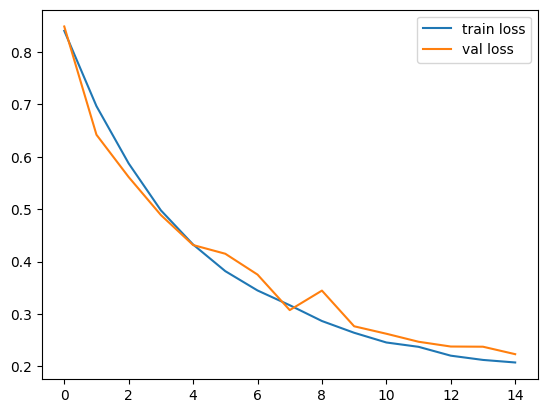

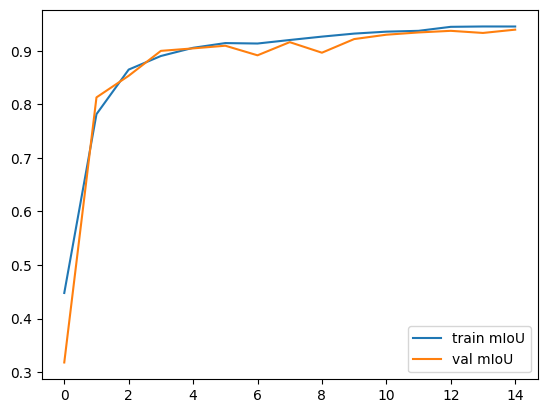

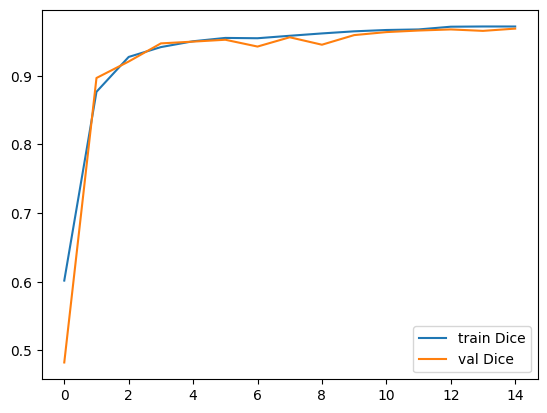

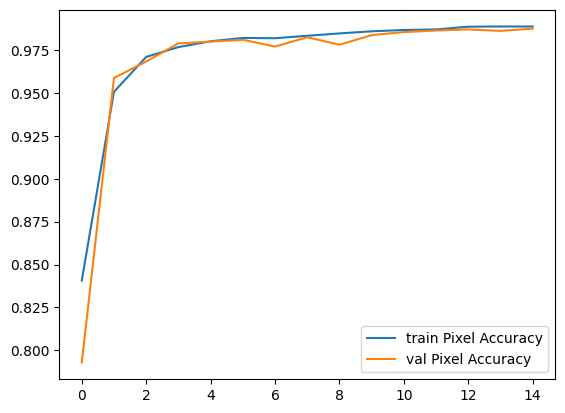

In [31]:
plt.plot(train_losses, label = 'train loss')
plt.plot(val_losses, label = 'val loss')
plt.legend()
plt.show()
plt.plot(train_IoUs, label = 'train mIoU')
plt.plot(val_IoUs, label = 'val mIoU')
plt.legend()
plt.show()
plt.plot(train_Dices, label = 'train Dice')
plt.plot(val_Dices, label = 'val Dice')
plt.legend()
plt.show()
plt.plot(train_PAs, label = 'train Pixel Accuracy')
plt.plot(val_PAs, label = 'val Pixel Accuracy')
plt.legend()
plt.show()

In [32]:
def plot_batch(model, data_loader):
    model.eval()
    with torch.no_grad():
        for img, mask in tqdm(data_loader):
            img = img.to(device)
            output = model(img)
            
            # output에서 가장 높은 클래스 인덱스 선택 (배치에서 각 픽셀별로 argmax)
            output = torch.argmax(output, dim=1).cpu().numpy()  # (batch_size, H, W)
            
            img = img.cpu().numpy().transpose(0, 2, 3, 1)  # (batch_size, H, W, 3)
            mask = mask.cpu().numpy()  # (batch_size, H, W)
            break
    
    for i in range(data_loader.batch_size):
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        
        # 원본 이미지 시각화
        ax[0].imshow(img[i])
        ax[0].set_title('image')
        
        # 마스크 시각화 (vmin=0, vmax=5로 클래스 범위를 설정)
        ax[1].imshow(mask[i], cmap='gray', vmin=0, vmax=5)
        ax[1].set_title('mask')
        
        # 예측 마스크 시각화 (vmin=0, vmax=5로 클래스 범위를 설정)
        ax[2].imshow(output[i], cmap='gray', vmin=0, vmax=5)
        ax[2].set_title('predicted mask')
        
        plt.show()

  0%|          | 0/3 [00:00<?, ?it/s]

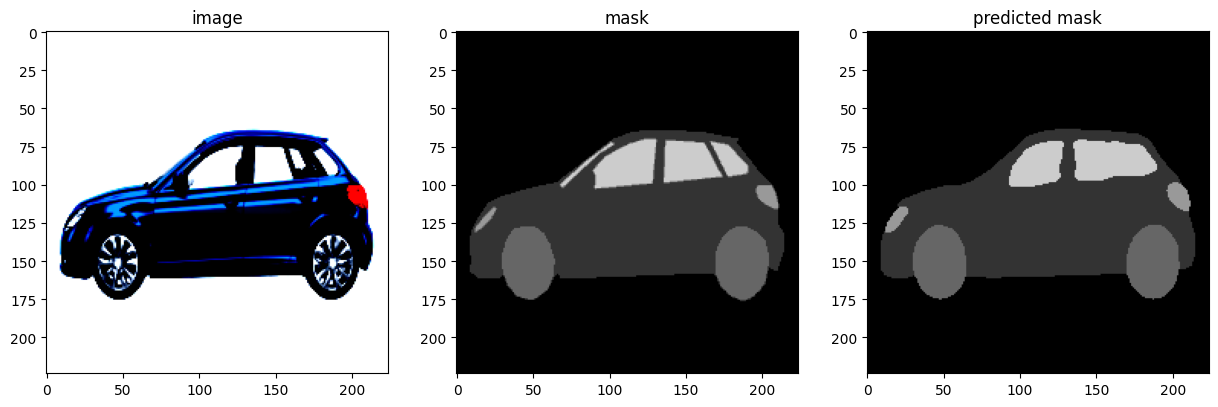

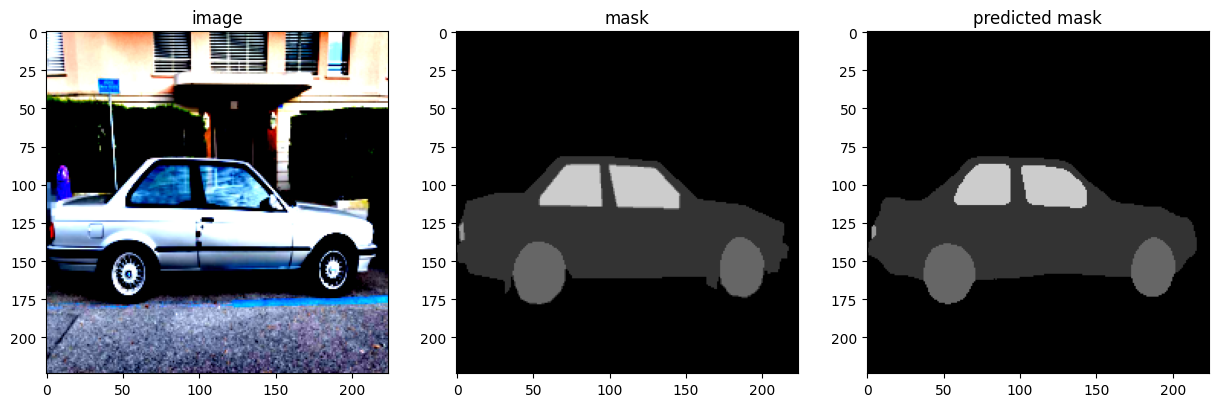

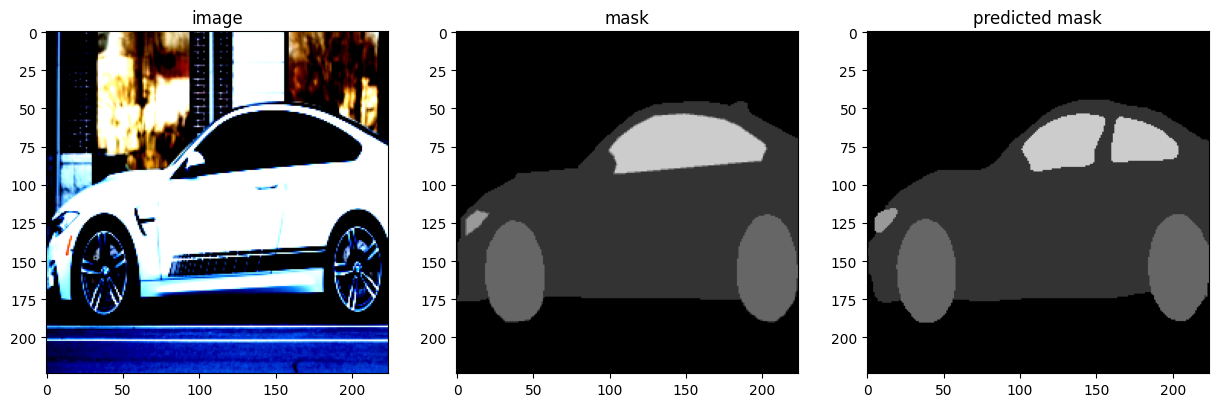

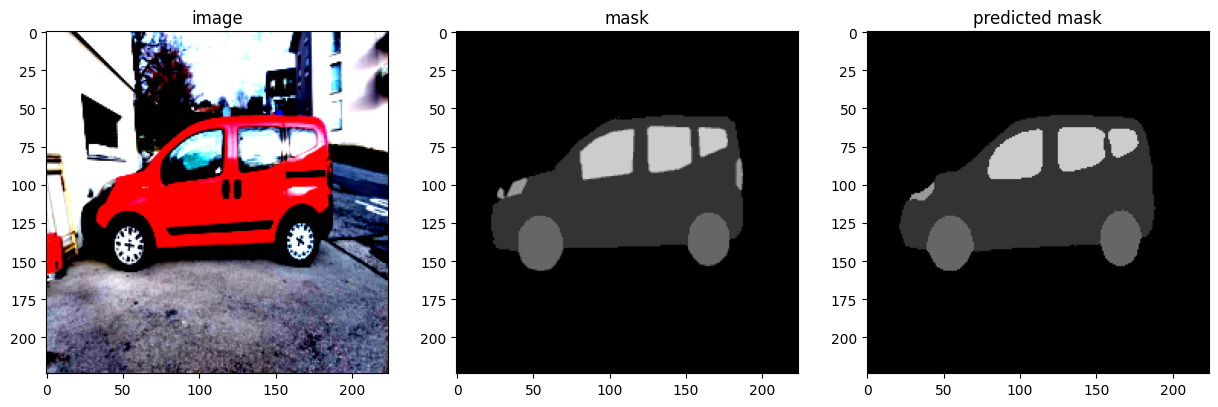

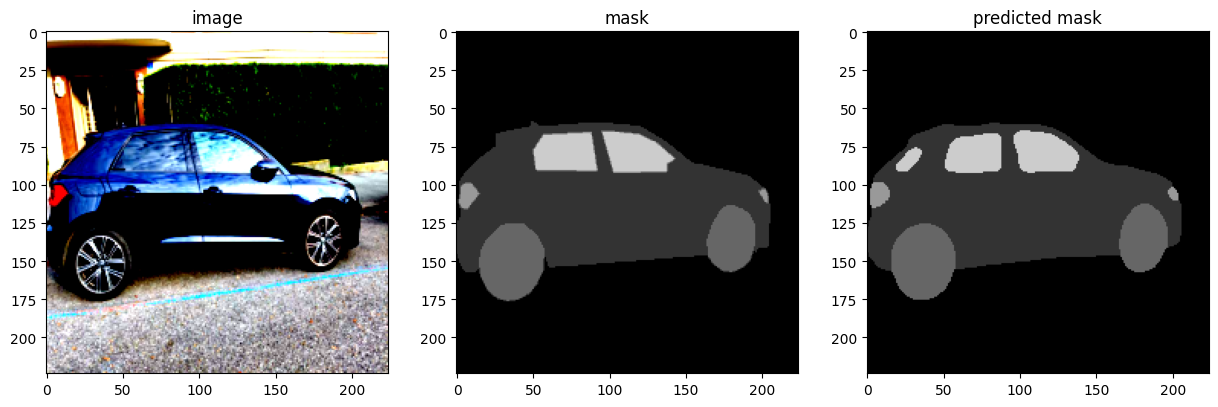

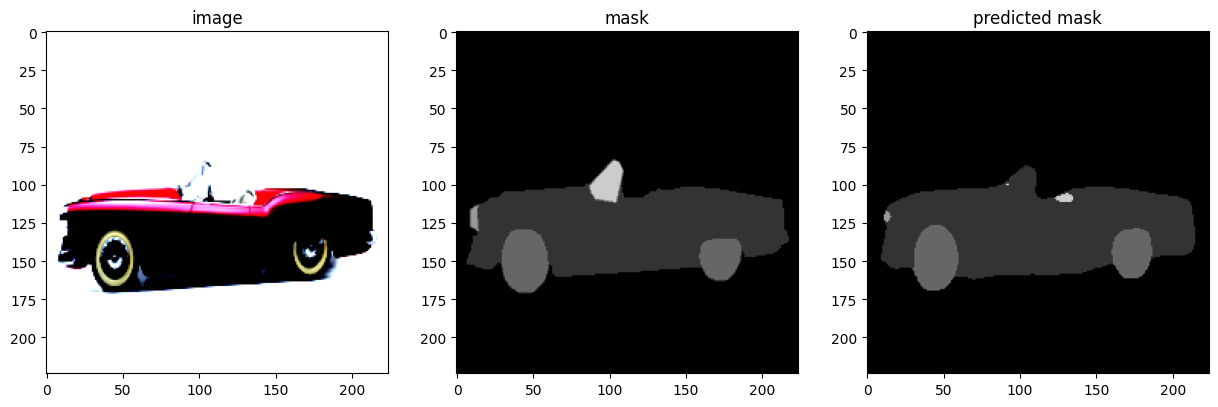

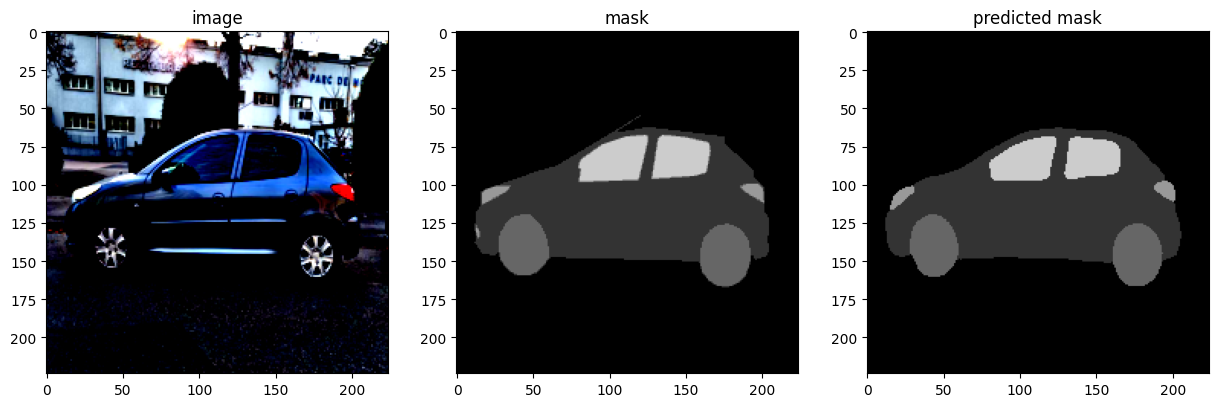

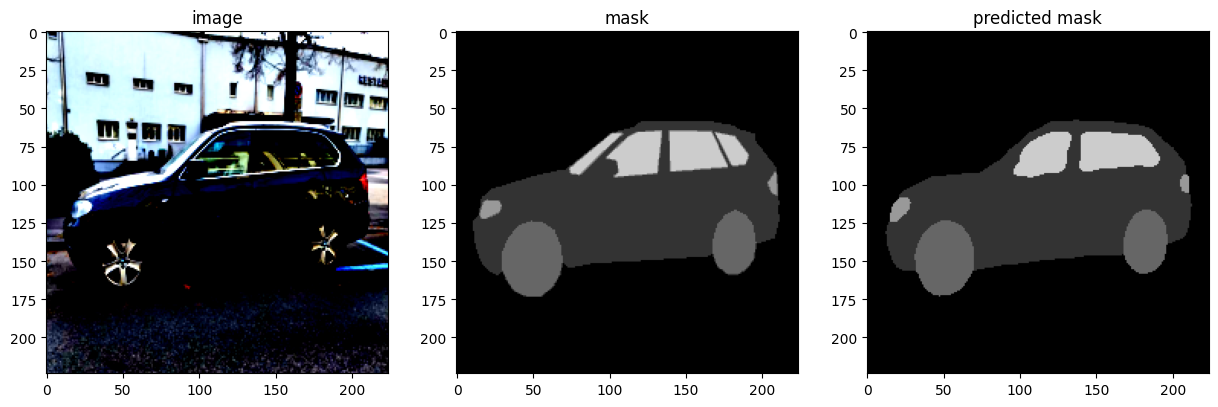

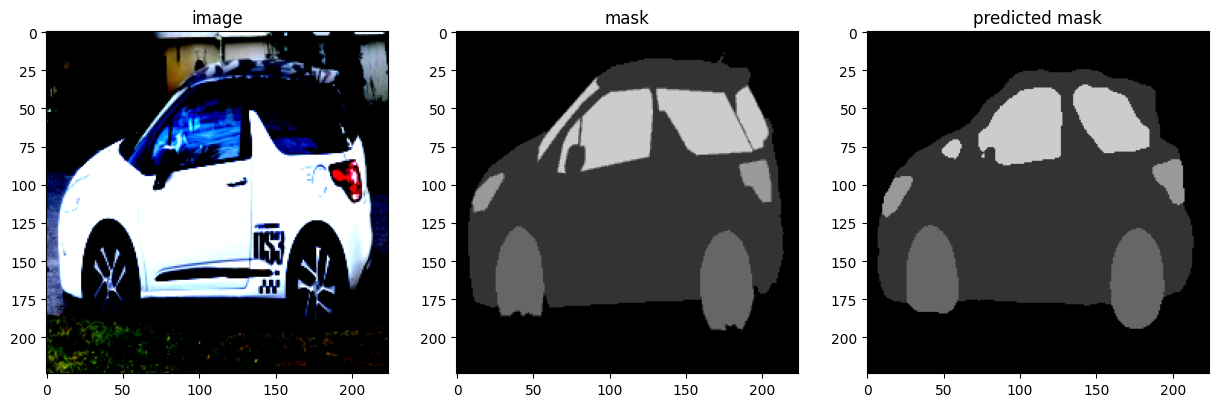

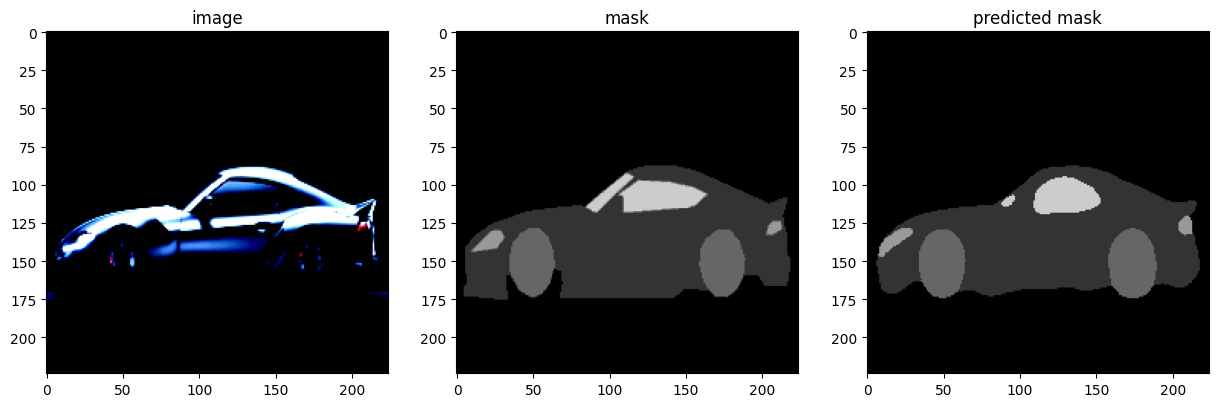

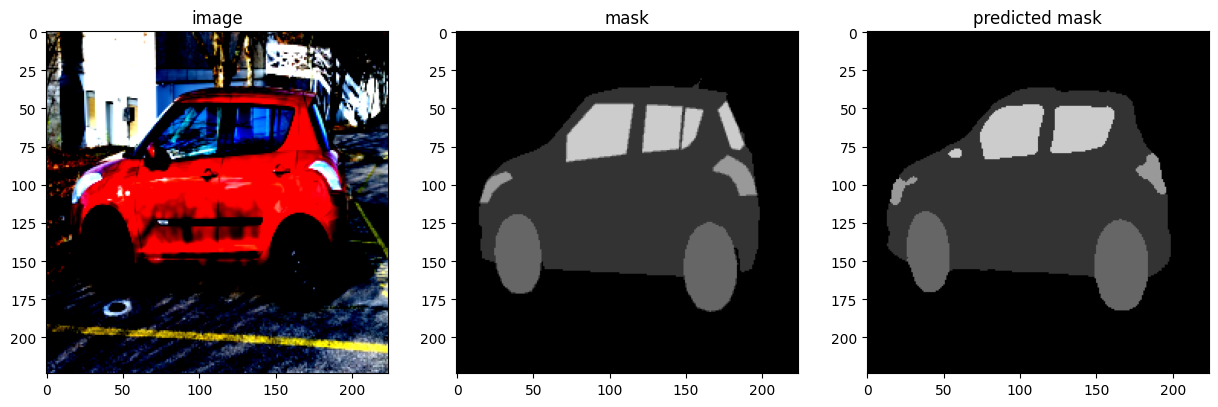

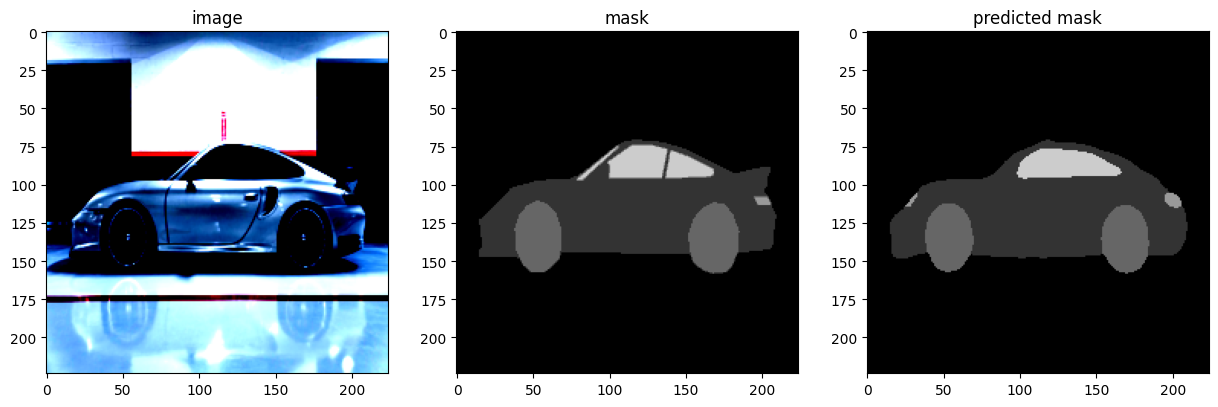

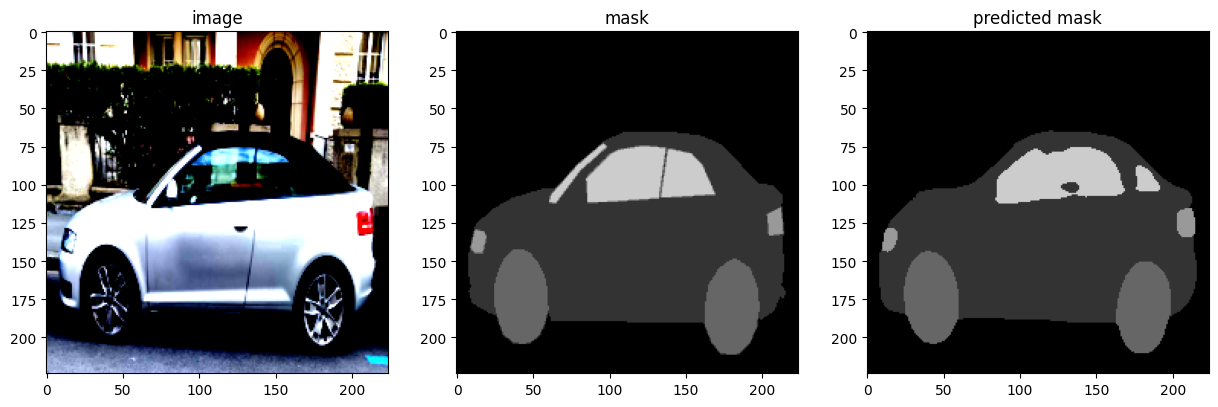

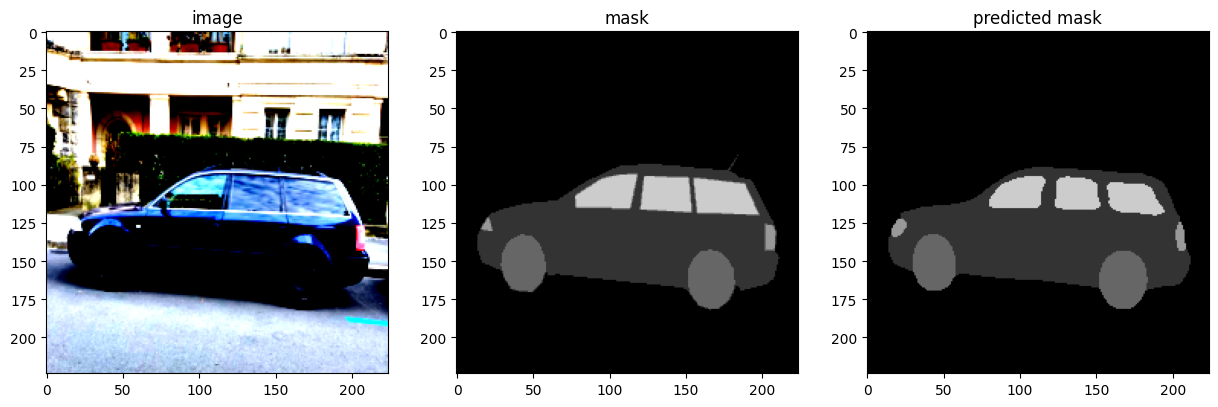

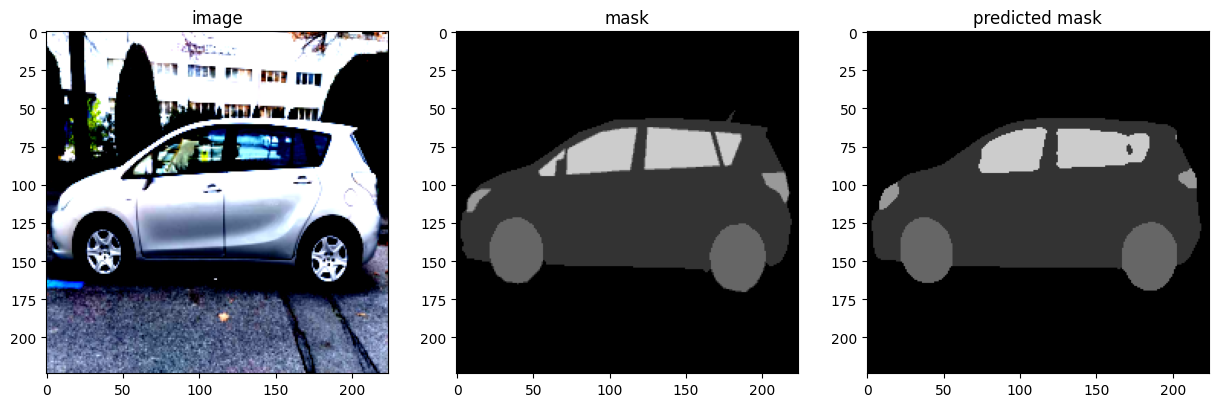

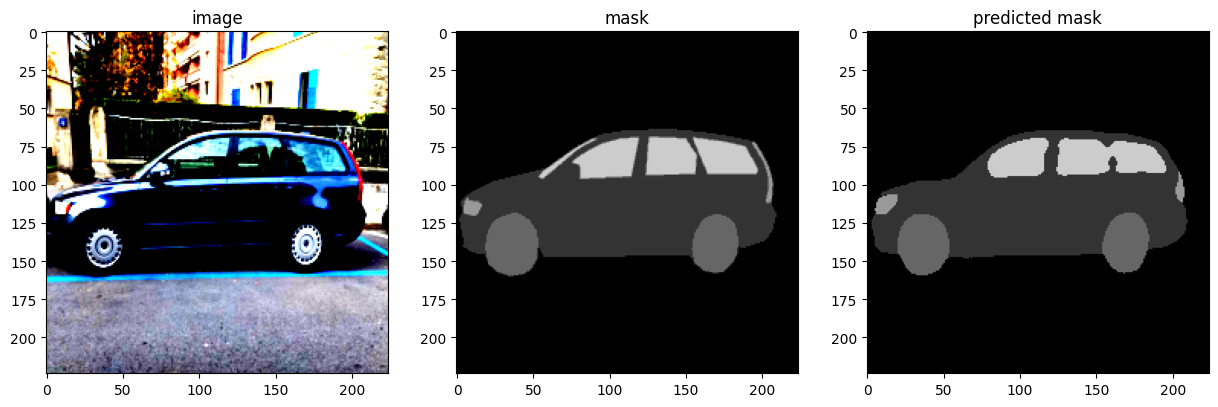

In [33]:
plot_batch(unet, val_dl)